# Generalize support of time-dimensional data

Data modelling =/= services =/= map.geo.admin.ch (**=> timeslider with different resolutions?**)

## Scenarios

### No time-dimensional data (raster and vector), can be e.g. 

Examples:
- an aggregated dataset with a time-like label (e.g. average temp 1980-2010 (meteoschweiz))
- a dataset which was assessed over a longer period (e.g. ch.swisstopo.vec25-gebaeude), can have a time-like label like e.g. "1998-2006" and a specified data status ('Datenstand') or `current`
- a dataset which was once assessed but is unlikely to change over time (e.g. `ch.swisstopo.geologie-geomol-temperaturverteilung_1000`), but might receive updates to change representation or the like
- unhistorized non-isochron realtime data (e.g. Naturgefahren)

**=> when is current used in DB, when a timestamp?**

### A layer which is available at discrete timestamps (raster and vector)
Examples:
- **?**

Representation:
- GetCap: 2004,2006,2007,2011
- time=2007
- default=2011

### Yearly data (raster and vector)
Examples:
- ch.swisstopo.zeitreihen (raster)
- **? (vector)**

Representation:
- GetCap: 2005/2019/P1Y
- time=2008
- label=2008
- default=2008
- special case: all data in range, with special case all data from 2005/2019, either 9999 or 2005--2019 or 2005--current (see standard)


### realtime or near-realtime data (isochron) (e.g. every 5 min)
Examples:

Representation:
- GetCap: 2005/2019/PT5M or 2005-11-01T10:15Z/2019-02-15T09:30Z/PT5M
- time=2010-11-13T10:10Z
- default=2019-02-15T09:30Z
- special case: **all data in range (see above), data every hour, time=2005 allowed? (for everything in that year), according to standard, it's possible**

### realtime or near-realtime data, not isochron
Examples:
- Diemo
- Naturgefahren

Representation:
- GetCap: 2005-11-01T10:15:00Z/2019-02-15T09:30:45Z/0 (from WMS standard: A resolution value of zero (as in min/max/0) means that the data are effectively at infinitely-fine resolution for the
purposes of making requests on the server. For instance, an instrument which continuously monitors randomly-
occurring data may have no explicitly defined temporal resolution.)
- time=2010-11-13T10:10Z--2019-02-15T09:30Z
- default=2019-02-15T09:30Z--2019-02-15T09:35Z

### quarterly data:
Examples:

Representation:
- GetCap: 2010-01/2019-06/P3M (it should be defined whether month defines start or end date of quarter
- time=2011-01 or time=2012-04

### Open questions
- changing resolution => several dimension tags with different 
- can `current` be used for all layers and denote the most recent timestamp available? (in case of not isochron data, an interval has to be defined per layer)
- cases like swissimage, which has a release every year but every release only updates part of the whole coverage, the rest is data from previous years


##### Layerdefinitions


| Layername | &nbsp;  | &nbsp; |
|---|:---|:---|
| **ch.ns1.layer1** | *only current data (which was generated e.g. at 2008-12-11)*  | &nbsp;  |
| &nbsp;  | tilesetA | 2008-12-11 |
| **ch.ns1.layer1** | *yearly isochron*  | &nbsp;  |
| &nbsp;  | tilesetA | 2005/2019/P1Y |
| **ch.ns1.layer2** | *5min isochron*  | &nbsp;  |
| &nbsp;  | tilesetA | 2005-11-01T10:15Z/2019-02-15T09:30Z/PT5M |
| **ch.ns2.layer1** | *discrete timestamps*  | &nbsp;  |
| &nbsp;  | tilesetA | 2004 |
| &nbsp;  | tilesetB | 2006 |
| &nbsp;  | tilesetC | 2007 |
| &nbsp;  | tilesetD | 2011 |

##### **Features with unique IDs and stable geometry**

| uid | timestamp (`DateTime`)  | the_geom | attr1 |
|---|---|---|---|
| 1 | 2017-12-01T11:30 | `POINT(4 6)` | 45 |
| 2 | 2017-12-01T11:30 | `POINT(5 7)` | 15 |
| 3 | 2017-12-01T11:30 | `POINT(3 6)` | 5 |
| 1 | 2017-12-01T11:35 | `POINT(4 6)` | 15 |
| 2 | 2017-12-01T11:35 | `POINT(5 7)` | 31 |
| 1 | 2017-12-01T11:40 | `POINT(4 6)` | 18 |
| 2 | 2017-12-01T11:40 | `POINT(5 7)` | 2 |
| 3 | 2017-12-01T11:40 | `POINT(3 6)` | 17 |

**=> When is time information explicitly given in tileset definition, when is it automatically derived from features?**

### Example with `vec25-gebaeude`
Each feature in `stopo_master:public.v25_geb_25_a` has a timestamp indicating the year of change (column `yearofchan`). Current values for the year of change are
```
stopo_master=> select distinct yearofchan from v25_geb_25_a order by yearofchan;
 yearofchan 
------------
       1984
       1988
       1992
       1994
       1995
       1996
       1997
       1998
       1999
       2000
       2001
       2002
       2003
       2004
       2005
       2006
```
where the `bgdi_modified` timestamp for all features is `2016-06-07 17:52:40.944934`, the timestamp of the tileset in `bod_master:public.ch.swisstopo.vec25-gebaeude` is 2009-04-01 (which is also the value in GetCapabilities), and the "Datenstand" in the legend is "1998-2006". 

- `timeenabled` info is in layers_js
- `datenstand` in `dataset_timestamps`

- how to handle e.g. zeitreihen: rasterdata, but a timestamp may not always cover the whole country, is 1845 only the map which was produced in 1845 or everything which was produced up to that point?
- timestamp shown on map e.g. for hochwasser from bafu?


## Including time parameter in wms
### WMS standard
Time in `WMS` standard is considered a dimension of multidimensional data (another might be e.g. elevation) and is described in Annex C of the WMS standard ([1]).
Quoting the standard for publishing the time dimension in GetCapabilities (using [ISO8601](https://en.wikipedia.org/wiki/ISO_8601) format standards):
>A Dimension element has the following format in XML:
>
>`<Dimension name="dimension_name" units=unit_name unitSymbol="symbol" default="default_value" multipleValues="0|1" nearestValue="0|1" current="0|1">extent</Dimension>`

where the `extent` can have one of the following formats

| Syntax  |  Meaning |
|---|---|
| `value`  | A single value.  |
| `value1,value2,value3,...`  | A list of multiple values.   |
| `min/max/resolution`  | An interval defined by its lower and upper bounds and its resolution.  |
| `min1/max1/res1,min2/max2/res2,...`  | A list of multiple intervals.  |

The time dimension is predefined as follows:

    <Dimension name="time" units="ISO8601" />

Quoting further:

>If a Layer has a Time dimension defined, then requests may include the parameter
>
>    `TIME=value.`
>
>In either case, value uses the format described in Table C.2 to provide a single value, a comma-separated list, or an interval of the form start/end without a resolution. value shall not contain white space. An  interval in a request value is a request for all the data from the start value up to and including the end value. The absence of Time [...] parameters in the request is equivalent to a request for the Layer’s default value (if defined) along that dimension (see C.4.2). All parameter names are case-insensitive as stated in 6.8.1, so, for example, “TIME”, “Time” and “time” are all acceptable. For the TIME parameter, the special keyword “current” may be used if the `<Dimension name="time">` service metadata element includes a nonzero value for the “current” attribute, as described in C.2. The expression “TIME=current” means “send the most current data available”. The expression “TIME=start_time/current” means “send data from start_time up to the most current data available”.

### WMS mapserver config
Mapserver allows for two different approaches to handle time, once as described in the standard via GetCapabilities -- referred to as WMS-T --, once using runtime substituion, where the `&time=YYYY` GET parameter of an HTTP request is parsed and substituted into the DB query.

#### WMS-T
BGDI is using the [WMS-T](https://mapserver.org/ogc/wms_time.html) definition, if the time capability of the layer should be visible in the GetCapabilities file. This is the case e.g. for [ch.bafu.gewaesserschutz-chemischer_zustand_nitrit.map](https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.bafu.gewaesserschutz-chemischer_zustand_nitrit.map) with the following definition
```
    ...
    METADATA
      "wms_enable_request" "*"
      "wms_timeextent" "2011/2015"
      "wms_timeitem" "bgdi_date"
      "wms_timeformat" "YYYY"
      "gml_featureid" "bgdi_id"
      "wms_extent" "2100000 1050000 2850000 1400000"
    END
    ...
```
which produces the following entry in [GetCapabilities](http://wms-bgdi.dev.bgdi.ch/ch.bafu.gewaesserschutz-chemischer_zustand_nitrit/?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities)
```
    ...
    <Dimension name="time" units="ISO8601" nearestValue="0">2011/2015</Dimension>
    ...
```
Time is interpreted as a real timestamp and needs a coresponding DateTime column (`bgdi_date` in most cases) in the DB.

#### Runtime substitution
If the time dimension should be available for GetMap but not be visible in GetCapabilities, [runtime substitution](https://mapserver.org/cgi/runsub.html) can be used, which allows to "to alter portions of a mapfile based on data passed via a CGI request". Hence `time=YYYY` can be passed as GET parameter and is parsed and used as parameter for the DB query. An example is is [ch.swisstopo.lubis-luftbilder_farbe](https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.swisstopo.lubis-luftbilder_farbe.map)
```
    ...
    VALIDATION
        "time" "^[0-9]{8}$"
        "default_time" "99991231"
    END
    ...
```
It's important to note that runtime substitution is a mere string matching and has no real time component. 


[1] http://portal.opengeospatial.org/files/?artifact_id=14416


### WMS Example
We use an example from the Iowa Environmental Mesonet (Iowa State University), a similar implementation is used e.g. also by the [European Centre for Medium-Range Weather Forecasts](www.ecmwf.int) in their [WMS](http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?SERVICE=WMS&request=GetCapabilities)

In [42]:
import requests
import xml.etree.ElementTree as ET
from display_xml import XML

# Get Capabilities of wms-t with desired format min/max/res
GetCapUrl = 'https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?service=wms&version=1.3.0&request=GetCapabilities'
resp = requests.get(GetCapUrl)

# register namespaces
namespaces = {
    'def': "http://www.opengis.net/wms",
    'sld': "http://www.opengis.net/sld",
    'xsi': "http://www.w3.org/2001/XMLSchema-instance",
    'ms': "http://mapserver.gis.umn.edu/mapserver"
}
for key,url in namespaces.items():
    if key == 'def':
        key = ''
    ET.register_namespace(key,url)

root = ET.fromstring(resp.text)

# find all Layer nodes that have a child node Name with content
# layername and evaluate the first one (there should only be one)
_l = ''
for layer in root.findall('.//def:Layer[def:Name="nexrad-n0r-wmst"]', namespaces):
    _l = ET.tostring(layer, encoding="unicode")
    break
XML(_l)


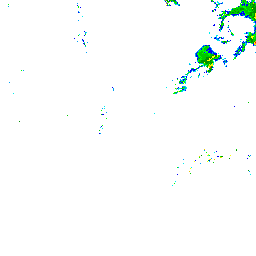

In [17]:
from IPython.core.display import Image, display
# obtain a Map extent at a specific time within the time series
GetMapUrlValid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15T15:10:00Z
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlValid)

display(Image(data=resp.content, format='jpg', unconfined=True))

In [27]:
import requests
import xml.etree.ElementTree as ET
from display_xml import XML
ET.register_namespace('', "http://www.opengis.net/ogc")

# the time must be specified down to 5 min, 'daily' aggregates don't make sense and
# result in an error
GetMapUrlInvalid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlInvalid)
XML(ET.tostring(ET.fromstring(resp.text), encoding="unicode"))

In [25]:
# https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/wmts.cgi?SERVICE=WMTS&REQUEST=GetCapabilities
# http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?SERVICE=WMS&request=GetCapabilities

## WMTS

Useful insights regarding time handling in wmts can be obtained from [NASA](https://wiki.earthdata.nasa.gov/pages/viewpage.action?pageId=14518214). Quoting

>The parts of the Dimension data structure are taken from the WMTS 1.0.0 spec (Table 9, p. 22) [1]. However, since the WMTS spec doesn't address the time dimension (other than the use of "Current"), we are adapting some aspects of the WMS spec regarding the time dimension, specifically:
>
>    *The contents of the <UOM> part match the contents of the "units=" attribute in the WMS <Dimension> element.*
>    *The contents of the <Value> part match the contents of the WMS <Extent> element.*
>
>If the time dimension is omitted in the WMTS request, tiles for the current UTC date will be returned. [...]
>
>We are working with the OGC WMS SWG to continue to growth of the WMTS standard and specifically to deal with limitations like this that we run into.
    
OGC has published an [Engineering Report](http://docs.opengeospatial.org/per/16-042r1.html#_time_varying_multi_dimension_eo_data_access_challenges) where they propose enhancements to the standard that exactly match the format defined in WMS and is currently already used by the NASA earthdata WMTS (see example below).

[1] http://portal.opengeospatial.org/files/?artifact_id=35326    
    
### Example
NASA earthdata WMTS:

In [36]:
import requests
import xml.etree.ElementTree as ET
from display_xml import XML

# Get Capabilities of wms-t with desired format min/max/res
GetCapUrl = 'https://map1.vis.earthdata.nasa.gov/wmts-geo/1.0.0/WMTSCapabilities.xml'
resp = requests.get(GetCapUrl)
# register namespaces
namespaces = {
    'def': "http://www.opengis.net/wmts/1.0",
    'ows': "http://www.opengis.net/ows/1.1",
    'xlink': "http://www.w3.org/1999/xlink",
    'xsi': "http://www.w3.org/2001/XMLSchema-instance",
    'gml': "http://www.opengis.net/gml"
}
for key,url in namespaces.items():
    if key == 'def':
        key = ''
    ET.register_namespace(key,url)

root = ET.fromstring(resp.text)

# find all Layer nodes that have a child node Identifier with text content
# according to layername in namespace `def` and
# evaluate first one (there should be only one...)
# <ows:Identifier>MODIS_Terra_CorrectedReflectance_TrueColor</ows:Identifier>
_l = ''
for layer in root.findall('.//def:Layer[ows:Identifier="MODIS_Terra_CorrectedReflectance_TrueColor"]', namespaces):
    _l = ET.tostring(layer, encoding="unicode")
    break
XML(_l)

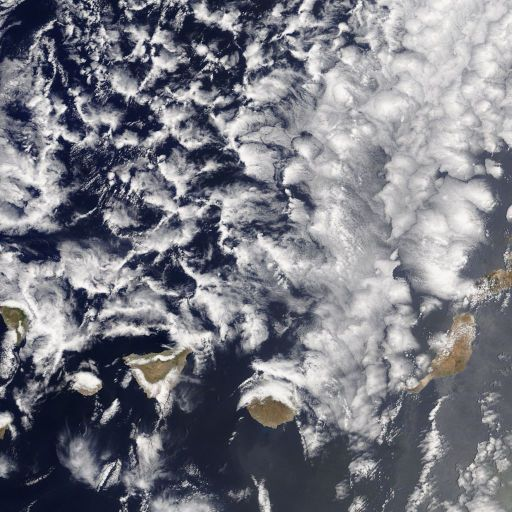

In [43]:
import requests
from IPython.core.display import Image, display
# obtain a Tile at a specific time within the time series
GetMapUrlValid = "https://map1.vis.earthdata.nasa.gov/wmts-geo/MODIS_Terra_CorrectedReflectance_TrueColor/default/2019-06-11/EPSG4326_250m/6/13/36.jpg"

resp = requests.get(GetMapUrlValid)

display(Image(data=resp.content, format='jpg', unconfined=True))

#### Support of Fatclients

Support of fatclients for the format min/max/resolution in WMS and WMTS is limited.

**ArcMap**:
- WMS time dimension with time format start/end/res is supported (time slider can be used),
- WMTS with same format is not (yet) supported (Feature request: https://esri.jiveon.com/ideas/13333-wmts-time-dimension-support)

**QGIS**:
- both WMS-T as well as WMTS with this time format is not (yet) natively supported (see: https://gis.stackexchange.com/questions/34667/does-qgis-have-wms-t-wms-with-time-support/153709, the answer is not brand-new, but it seem that it hasen't been resolved in QGIS 3, feature request: https://issues.qgis.org/issues/13085). There's however the plugin [TimeManager](https://anitagraser.com/2015/08/10/using-timemanager-for-wms-t-layers/) which offers limited support for time enabled layers.

